In [1]:

import os
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Import Data

In [2]:

X_raw = pd.read_csv('../data/X_train.csv', index_col=0)
y = pd.read_csv('../data/y_train.csv', index_col=0)
y[y == -1] = 0


In [3]:
# Drop Object Columns
X = X_raw.select_dtypes(exclude=['object'])

In [15]:
# OR, colnames of categorical columns
#categoricals = X_raw.select_dtypes('object').columns
#indexes_of_categories = [X_raw.columns.get_loc(col) for col in categoricals]
#indexes_of_categories
#X = X_raw

In [4]:
# Make Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# 01 - Naive LGB

In [5]:
# Naive LGBM

# If dropped categoricals
clf_naive = lgb.LGBMClassifier()
clf_naive.fit(X_train, y_train)

# OR, If including categoricals
#fit_params = {'categorical_feature':indexes_of_categories}
#clf_naive = lgb.LGBMClassifier()
#clf_naive.fit(X_train, y_train, fit_params)


/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier()

In [6]:
# Evaluate Train Accuracy
y_pred_train = clf_naive.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.79


In [11]:
# Evaluate Test Accuracy
y_pred = clf_naive.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.64


# 02 - Some Tuning

In [7]:
# Prepare lbg dataset
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [8]:
# Train Model
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.01,
    "objective": "multiclass",
    "boost_from_average": True,
    "early_stopping_round": 50,
    "num_class" : 5
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=d_test,
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 420
[LightGBM] [Info] Start training from score -4.282397
[LightGBM] [Info] Start training from score -1.579677
[LightGBM] [Info] Start training from score -1.216351
[LightGBM] [Info] Start training from score -1.261657
[LightGBM] [Info] Start training from score -1.606169
[1]	valid_0's multi_logloss: 1.41873
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.41033
[3]	valid_0's multi_logloss: 1.40196
[4]	valid_0's multi_logloss: 1.39491
[5]	valid_0's multi_logloss: 1.38682
[6]	valid_0's multi_logloss: 1.37897
[7]	valid_0's multi_logloss: 1.37173
[8]	valid_0's multi_logloss: 1.36466
[9]	valid_0's mu

In [9]:
# Evaluate Train Accuracy
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.74


In [10]:
# Evaluate Test Accuracy
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
train_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {train_accuracy:.2f}')

Test Accuracy: 0.64


In [12]:
# Cross Validation Score
cv_results = lgb.cv(
    params,
    d_train,
    num_boost_round=10000,
    nfold=5,
    early_stopping_rounds=100,
    metrics='multi_logloss',
    stratified=False
)
cv_results['multi_logloss-mean'][-1]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 26880, number of used features: 420
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 26880, number of used features: 420
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Numbe

0.8514311485475863

# Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

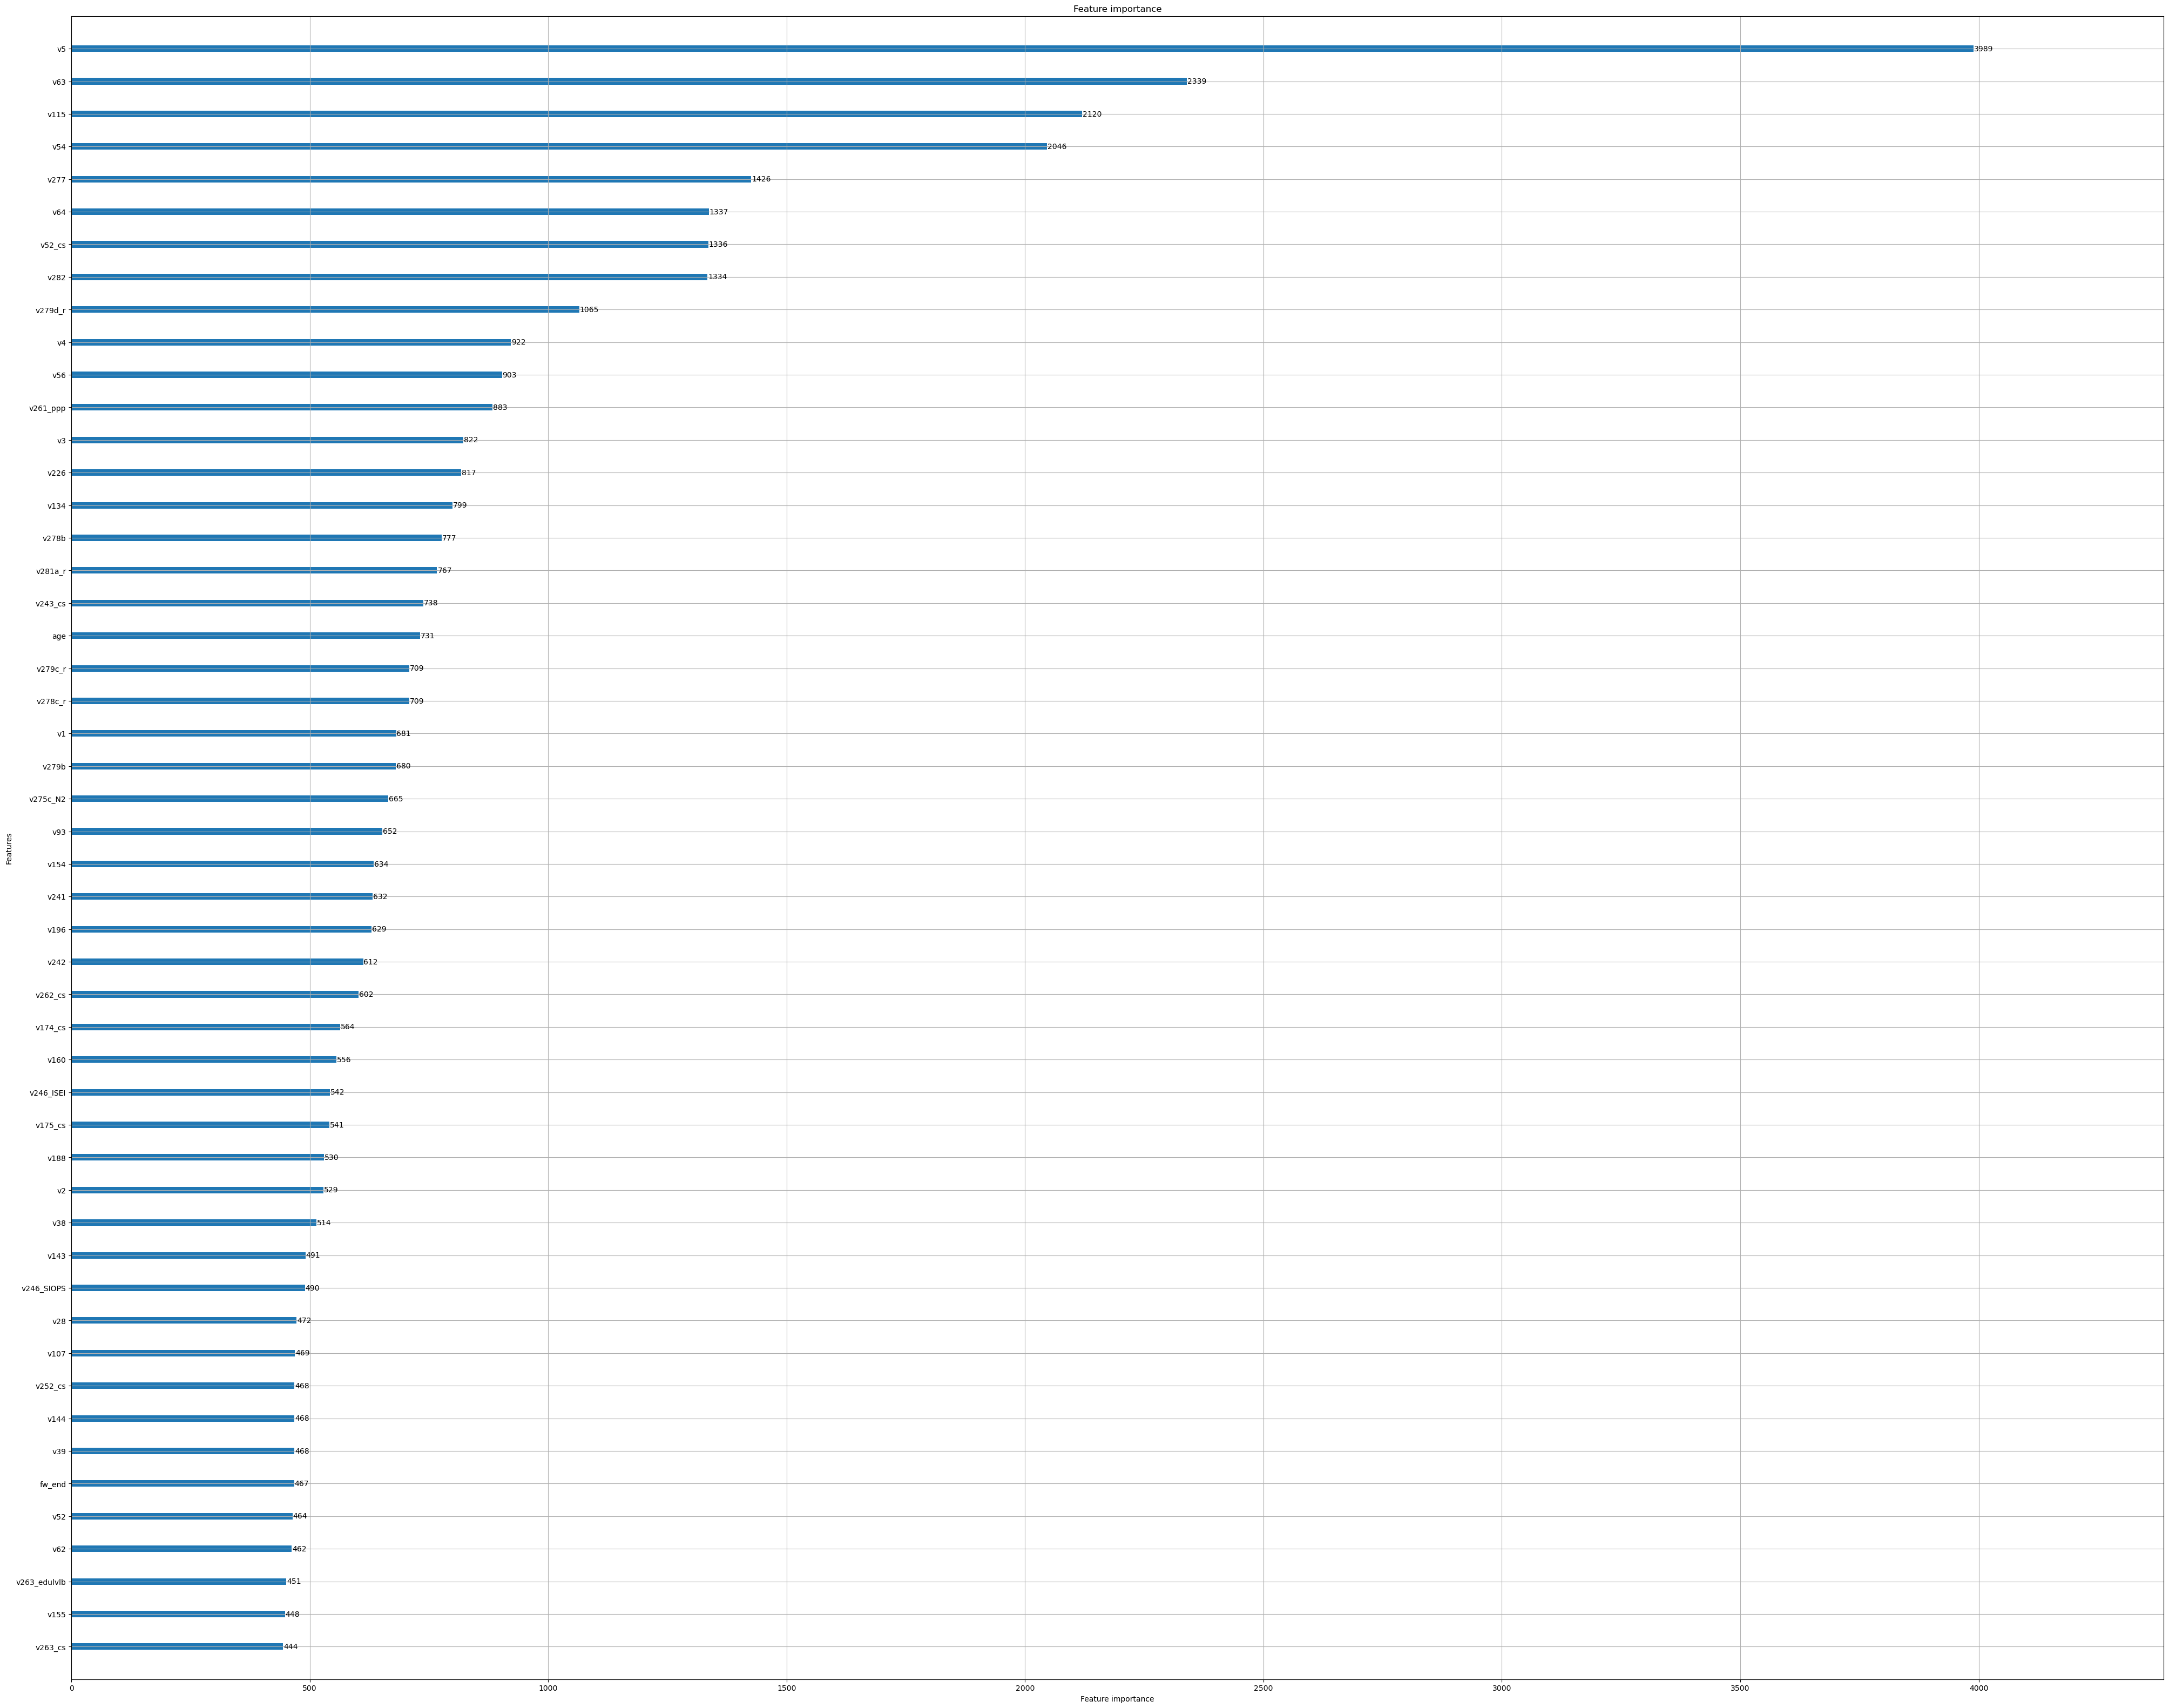

In [13]:
lgb.plot_importance(model, max_num_features=50, figsize=(50,40))

In [20]:
correlation_matrix

,year,fw_start,fw_end,country,v1,v2,v3,v4,v5,v7,...,v278a,v278b,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a_r,v282
year,1.000000,0.968323,0.871467,0.060843,-0.021577,-0.011304,0.060101,0.026264,0.090543,0.041457,...,0.184446,0.048411,0.184291,0.188759,0.065621,0.189006,0.015879,0.199756,0.134743,0.357401
fw_start,0.968323,1.000000,0.873242,0.030653,-0.022313,-0.021056,0.051558,0.020063,0.074035,0.052603,...,0.129996,0.039151,0.130076,0.133112,0.046094,0.133290,-0.013379,0.182452,0.153473,0.364541
fw_end,0.871467,0.873242,1.000000,0.069913,-0.028712,-0.023302,0.033438,-0.007340,0.029874,0.026376,...,0.030939,0.008498,0.030905,0.032738,0.007379,0.032625,-0.011129,0.094914,0.001020,0.352525
country,0.060843,0.030653,0.069913,1.000000,0.026252,0.016740,-0.028366,-0.088150,-0.028830,-0.041012,...,0.027353,0.021746,0.027803,0.017969,0.021547,0.018456,-0.016889,0.200792,0.449129,0.125641
v1,-0.021577,-0.022313,-0.028712,0.026252,1.000000,0.178250,0.135168,0.126002,0.081854,0.055599,...,-0.032619,-0.013473,-0.032748,-0.029841,-0.020087,-0.030189,-0.015948,-0.063088,-0.020965,0.003964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v279c_r,0.189006,0.133290,0.032625,0.018456,-0.030189,0.017826,0.028328,0.031225,0.076533,0.007943,...,0.966650,0.302246,0.968009,0.999476,0.310642,1.000000,0.331721,0.295558,0.182299,0.040124
v279d_r,0.015879,-0.013379,-0.011129,-0.016889,-0.015948,-0.005874,0.014620,0.019800,-0.012810,-0.007277,...,0.183953,0.105234,0.185601,0.330727,0.130079,0.331721,1.000000,0.090569,0.006050,-0.015516
v280,0.199756,0.182452,0.094914,0.200792,-0.063088,0.020051,0.030532,0.041924,0.076696,0.035971,...,0.296808,0.132031,0.298375,0.293849,0.144137,0.295558,0.090569,1.000000,0.253541,0.059175
v281a_r,0.134743,0.153473,0.001020,0.449129,-0.020965,0.004972,0.025141,-0.024837,0.070399,0.048791,...,0.181980,0.041655,0.181627,0.181994,0.065055,0.182299,0.006050,0.253541,1.000000,0.151848


# Submission

In [18]:
X_test_subm = pd.read_csv('../data/X_test.csv', index_col=0)
X_test_subm = X_test_subm.select_dtypes(exclude=['object'])

In [19]:
# Train Model on Full Data
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.05,
    "objective": "multiclass",
    "boost_from_average": True,
    "num_class" : 5,
}

final_model = lgb.LGBMRegressor(**params)
final_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 420
[LightGBM] [

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, boost_from_average=True,
              feature_fraction=0.8, learning_rate=0.05, metric='multi_logloss',
              num_class=5, num_leaves=10, objective='multiclass')

In [20]:
predictions = final_model.predict(X_test_subm)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [21]:
# Make a df of preds
preds_df = pd.DataFrame(predictions, columns=['no answer', 'very important', 'quite important', 'not important', 'not at all important'])
preds_df.index.name = 'id'
print(preds_df.shape)
preds_df.head()

(11438, 5)


,no answer,very important,quite important,not important,not at all important
id,,,,,
0,0.003306,0.624920,0.180274,0.150321,0.041179
1,0.008152,0.114442,0.751024,0.110637,0.015745
2,0.015958,0.196130,0.386632,0.356443,0.044838
3,0.013057,0.159865,0.586740,0.187066,0.053272
4,0.006788,0.311724,0.545037,0.114975,0.021477


In [22]:
# Save to CSV
preds_df.to_csv('../data/predictions2.csv')
